Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
Total images: 87000
Using 10% of dataset: 8700 images
Training samples: 6960, Validation samples: 1740
batch size = 32, lr = 1e-3
Epoch [1/20] - Loss: 2.5274, Train Acc: 25.86%, Val Acc: 51.49%
Epoch [2/20] - Loss: 0.8723, Train Acc: 71.80%, Val Acc: 74.60%
Epoch [3/20] - Loss: 0.3382, Train Acc: 88.76%, Val Acc: 79.37%
Epoch [4/20] - Loss: 0.1910, Train Acc: 93.71%, Val Acc: 81.09%
Epoch [5/20] - Loss: 0.1032, Train Acc: 96.82%, Val Acc: 81.38%
Checkpoint saved at epoch 5
Epoch [6/20] - Loss: 0.0893, Train Acc: 96.98%, Val Acc: 80.57%
Epoch [7/20] - Loss: 0.0937, Train Acc: 97.28%, Val Acc: 81.55%
Epoch [8/20] - Loss: 0.0731, Train Acc: 97.79%, Val Acc: 82.99%
Epoch [9/20] - Loss: 0.0462, Train Acc: 98.69%, Val Acc: 82.64%
Epoch [10/20] - Loss: 0.0364, Train Acc: 98.85%, Val Acc: 81.55%
Checkpoint saved at epoch 10
Epoch

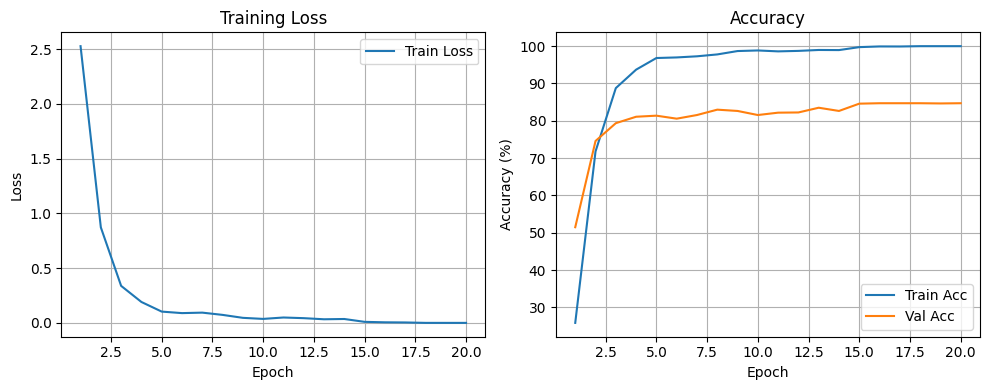

AttributeError: 'function' object has no attribute 'eval'

In [ ]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, Subset, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import random
import matplotlib.pyplot as plt

# ----------------------------
# Part A. Data Collection [5 pt]
# ----------------------------
dataFilePath = "~/asl_alphabet_train/asl_alphabet_train"

transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

dataset = datasets.ImageFolder(root=dataFilePath, transform=transform)

print("Classes:", dataset.classes)
print("Total images:", len(dataset))

# Use only 10% of the dataset because 87,000 images is too much
subset_size = int(0.1 * len(dataset))
subset_indices = random.sample(range(len(dataset)), subset_size)
subset_dataset = Subset(dataset, subset_indices)
print(f"Using 10% of dataset: {len(subset_dataset)} images")

# 80% train, 20% validation
train_size = int(0.8 * len(subset_dataset))
val_size = len(subset_dataset) - train_size
train_dataset, val_dataset = random_split(subset_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")

# --------------------------------
# Part B. Building a CNN [35 pt]
# --------------------------------

# 1a-b Buila CNN Model

class ASLNet(nn.Module):
    def __init__(self, num_classes=29):  # A-Z + del + nothing + space
        super(ASLNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 25 * 25, 256)  # for 200x200 input
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = ASLNet(num_classes=29)

# 1b-c Training Function

def train_model(model, train_dataset, val_dataset=None, batch_size=32, lr=1e-3, num_epochs=10, 
                checkpoint_path="checkpoint.pth", checkpoint_freq=5, plot_curve=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) if val_dataset else None

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, train_accuracies, val_accuracies = [], [], []

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / total
        train_acc = 100.0 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation
        if val_loader:
            model.eval()
            val_correct, val_total = 0, 0
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    _, predicted = outputs.max(1)
                    val_total += labels.size(0)
                    val_correct += predicted.eq(labels).sum().item()
            val_acc = 100.0 * val_correct / val_total
            val_accuracies.append(val_acc)
            print(f"Epoch [{epoch}/{num_epochs}] - Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")
        else:
            print(f"Epoch [{epoch}/{num_epochs}] - Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")

        # Checkpoint
        if epoch % checkpoint_freq == 0:
            torch.save(model.state_dict(), f"{checkpoint_path}_epoch{epoch}.pth")
            print(f"Checkpoint saved at epoch {epoch}")

    # Save final model
    torch.save(model.state_dict(), f"{checkpoint_path}_final.pth")

    # Plots training accuracy and loss
    if plot_curve:
        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1)
        plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.grid(True)
        plt.legend()

        plt.subplot(1,2,2)
        plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Acc')
        if val_loader:
            plt.plot(range(1, num_epochs+1), val_accuracies, label='Val Acc')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.title('Accuracy')
        plt.grid(True)
        plt.legend()

        plt.tight_layout()
        plt.show()

# 4. Hyperparameter Search

os.makedirs("checkpoints", exist_ok=True)
checkpoint_path = "checkpoints/asl_model"

# Test 1

#print("batch size = 16, lr = 1e-3")
#model = ASLNet(num_classes=29)  # new instance
#train_model(model, train_dataset, val_dataset, batch_size=16, lr=1e-3, num_epochs=20,
            #checkpoint_path=None, plot_curve=True)
# Test 2

#print("batch size = 32, lr = 1e-4")
#model = ASLNet(num_classes=29)  # new instance
#train_model(model, train_dataset, val_dataset, batch_size=32, lr=1e-4, num_epochs=20,
            #checkpoint_path=None, plot_curve=True)
# Test 3

#print("batch size = 16, lr = 1e-4")
#model = ASLNet(num_classes=29)  # new instance
#train_model(model, train_dataset, val_dataset, batch_size=16, lr=1e-4, num_epochs=20,
            #checkpoint_path=None, plot_curve=True)
# Test 4

print("batch size = 32, lr = 1e-3")
model = ASLNet(num_classes=29)  # new instance
train_model(model, train_dataset, val_dataset, batch_size=32, lr=1e-3, num_epochs=20,
            checkpoint_path=None, plot_curve=True)

# ----------------------------------------------------------------------------------------------------------------------
# Part C. Transfer Learning [15 pt]
# ----------------------------------------------------------------------------------------------------------------------


# 5a. Load pretrained AlexNet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

loader = DataLoader(subset_dataset, batch_size=32, shuffle=False)

alexnet = models.alexnet(pretrained=True).to(device)
alexnet.eval()

# 5b. Extract AlexNet features

features_list = []
labels_list = []

with torch.no_grad():
    for imgs, labels in loader:
        imgs = imgs.to(device)
        feats = alexnet.features(imgs)
        features_list.append(feats.cpu())
        labels_list.append(labels)

# Concatenate all batches
features = torch.cat(features_list)
labels = torch.cat(labels_list)

# Save
torch.save(features, "alexnet_features.pt")
torch.save(labels, "alexnet_labels.pt")

print("Features shape:", features.shape)
print("Labels shape:", labels.shape)

# 5c. Flatten features and prepare dataset

features_flat = features.view(features.size(0), -1)

dataset = TensorDataset(features_flat, labels)

# Split into train/val/test (e.g., 70/15/15)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# 5d. Feature Classifier

class FeatureClassifier(nn.Module):
    def __init__(self, input_dim=256*5*5, hidden_dim=512, num_classes=29):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = FeatureClassifier().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 10

# 5e. Training loop for feature classifier

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0
    
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        X = X.view(X.size(0), -1)
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        
        # Update metrics
        running_loss += loss.item() * X.size(0)
        _, predicted = outputs.max(1)
        total += y.size(0)
        correct += predicted.eq(y).sum().item()
    
    train_loss = running_loss / total
    train_acc = 100 * correct / total
    
    # Validation
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs_val = model(X_val)
            _, predicted_val = outputs_val.max(1)
            val_total += y_val.size(0)
            val_correct += predicted_val.eq(y_val).sum().item()
    val_acc = 100 * val_correct / val_total
    
    print(f"Epoch {epoch+1}: Loss={train_loss:.4f}, Train Acc={train_acc:.2f}%, Val Acc={val_acc:.2f}%")

# 5f. Test accuracy

model.eval()
test_correct, test_total = 0, 0
with torch.no_grad():
    for X_test, y_test in test_loader:
        X_test, y_test = X_test.to(device), y_test.to(device)
        outputs_test = model(X_test)
        _, predicted_test = outputs_test.max(1)
        test_total += y_test.size(0)
        test_correct += predicted_test.eq(y_test).sum().item()

test_acc = 100 * test_correct / test_total
print("Test Accuracy:", test_acc)

